In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import networkx as nx
from pgmpy.estimators import PC # %pip install pgmpy
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
from dotenv import load_dotenv
os.chdir("..")

load_dotenv("globs.env")
tickers   = os.getenv("TICKERS").split(",")
media_dir = os.getenv("MEDIA_DIR")
data_dir  = os.getenv("DATA_DIR")

import logging
from scripts.utils import log

LOG_FILE = "logs/pc_algorithm.log"

class PgmpyToUtils(logging.Handler):
    def emit(self, record):
        log(record.getMessage(), LOG_FILE, level=record.levelname, echo=False)

pgmpy_logger = logging.getLogger("pgmpy")
pgmpy_logger.propagate = False
pgmpy_logger.handlers.clear()
pgmpy_logger.addHandler(PgmpyToUtils())
pgmpy_logger.setLevel(logging.INFO)

In [2]:
## Load data
df = pd.read_csv(data_dir + "/returns.csv").set_index("date").ffill() # handle NaN


df = df.apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all")
X = (df - df.mean()) / df.std(ddof=0)
n, p = X.shape
print(f"n x p:", (n, p))

n x p: (1222, 15)


In [3]:
def fisher_z_ci_test(X, i, j, cond_set=None, significance_level=0.05):
    """
    Fisher-Z conditional independence test
    """
    cond_set = [] if cond_set is None else list(cond_set)
    cols = [i, j] + cond_set
    data = X[cols].dropna()

    corr = np.corrcoef(data.values, rowvar=False)
    try:
        prec = np.linalg.inv(corr)
    except np.linalg.LinAlgError:
        return False  # treat as dependent if singular

    rho = -prec[0, 1] / np.sqrt(prec[0, 0] * prec[1, 1])
    n = data.shape[0]
    z = 0.5 * np.log((1 + rho) / (1 - rho))
    stat = np.sqrt(max(n - len(cond_set) - 3, 1)) * abs(z)
    crit = norm.ppf(1 - significance_level / 2)
    return stat <= crit  # True = independent

def run_pc(X, alpha):
    pc = PC(X)

    def ci_wrapper(x, y, z, **kwargs):
        return fisher_z_ci_test(X, x, y, z, significance_level=alpha)

    model = pc.estimate(
        significance_level=alpha,
        ci_test=ci_wrapper,
        n_jobs=1,
        show_progress=False
    )

    # Extract graph in a robust way
    if isinstance(model, (nx.Graph, nx.DiGraph)):
        G = model
    elif hasattr(model, "to_networkx"):
        G = model.to_networkx()
    elif hasattr(model, "to_digraph"):
        G = model.to_digraph()
    elif hasattr(model, "graph") and model.graph is not None:
        G = model.graph
    elif isinstance(model, dict) and "graph" in model:
        G = model["graph"]
    else:
        # manual fallback
        G = nx.DiGraph()
        try:
            G.add_nodes_from(model.nodes)
            G.add_edges_from(model.edges)
        except Exception as e:
            raise TypeError(f"Could not extract graph structure: {e}")

    return G, {"Nodes": len(G.nodes()), "Edges": len(G.edges())}

def plot_graph(G, title, ax=None):
    pos = nx.spring_layout(G, seed=42, k=3, iterations=300)

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 7))

    nx.draw_networkx_edges(
        G, pos, ax=ax,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=12,
        width=1.5,
        edge_color="gray",
        connectionstyle="arc3,rad=0.1",
        alpha=0.5
    )
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=450,
        node_color="lightsteelblue",
        edgecolors="black",
        linewidths=1.0,
        alpha=0.5
    )
    nx.draw_networkx_labels(
        G, pos, ax=ax,
        font_size=6,
        font_weight="semibold",
        font_color="black"
    )

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(title, fontsize=12, pad=8)

100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


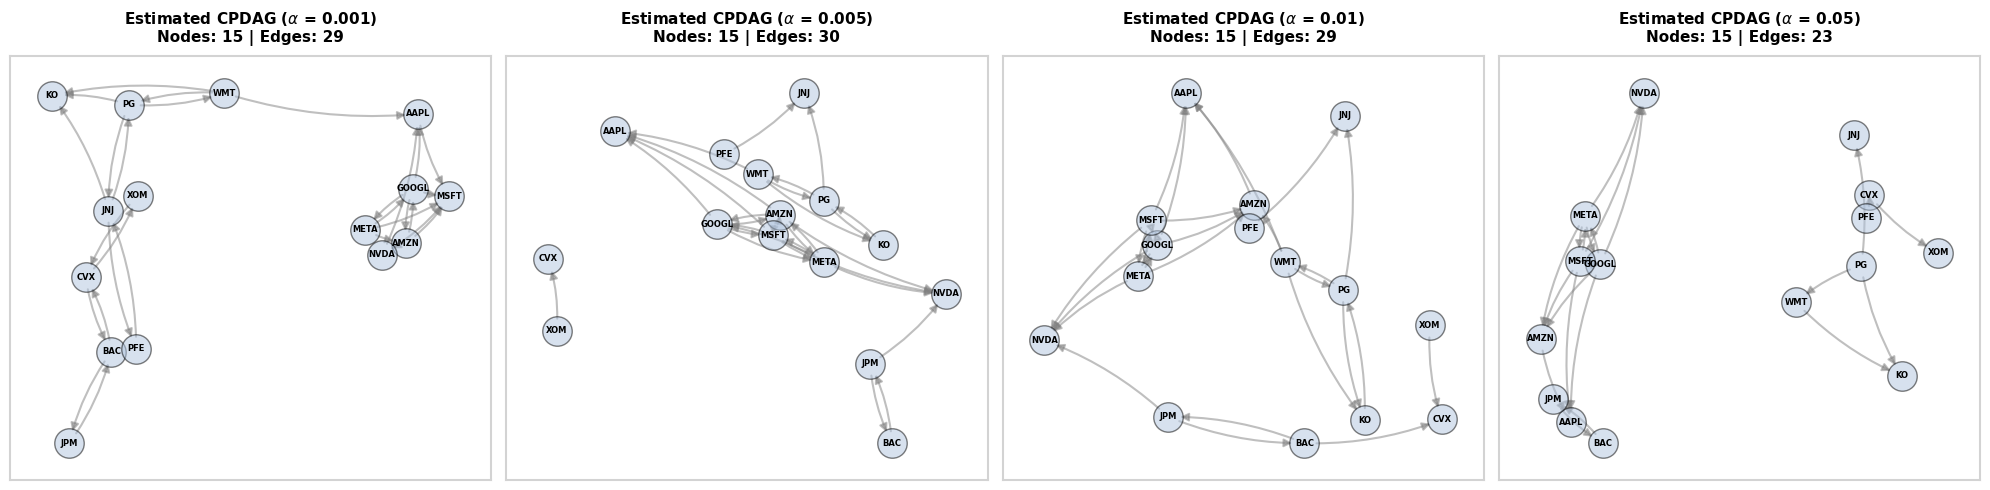

In [4]:
# Run PC for several α levels
alphas = [0.001, 0.005, 0.01, 0.05]
graphs = {}
k = len(alphas)

fig, axes = plt.subplots(1, len(alphas), figsize=(5*len(alphas), 5))
for ax, alpha in tqdm(zip(axes, alphas), total=len(alphas)):
    G, dict_ = run_pc(X, alpha)
    graphs[alpha] = G
    plot_graph(G, "", ax=ax)
    ax.set_title(
        rf"Estimated CPDAG ($\alpha$ = {alpha})" "\n"
        rf"Nodes: {dict_['Nodes']} | Edges: {dict_['Edges']}",
        fontsize=11,
        pad=10,
        backgroundcolor="white",
        fontweight="semibold"
    )
    ax.set_frame_on(True)
    for spine in ax.spines.values():
        spine.set_edgecolor("lightgray")
        spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig(media_dir + "/pc_algorithm_on_alpha_grid.png")
plt.show()

In [5]:
def pc_algorithm_hyperparameter_tuning(
    X, alpha_star=0.001, B=300,
    thr_list = [0.75, 0.90, 0.95, 0.99, 1.0],
    savepath1=None, 
):
    n, p = X.shape
    nodes = list(X.columns)
    node_index = {node: idx for idx, node in enumerate(nodes)}
    print(f"Using chosen alpha_star = {alpha_star}")

    # Fit PC at alpha_star
    G_full, stats_full = run_pc(X, alpha_star)
    print(f"Full-data PC graph: nodes={stats_full['Nodes']} edges={stats_full['Edges']}")

    # Build adjacency matrix
    A_full = np.zeros((p, p), dtype=int)
    for (u, v) in G_full.to_undirected().edges():
        i = node_index[u]
        j = node_index[v]
        A_full[i, j] = 1
        A_full[j, i] = 1

    # Stability selection (bootstrap)
    print(f"Running PC bootstrap with B={B}...")

    sel_counts = np.zeros((p, p))

    for b in tqdm(range(B), desc="Bootstrapping PC"):
        idx = np.random.choice(n, size=n, replace=True)
        Xb = X.iloc[idx, :]

        Gb, _ = run_pc(Xb, alpha_star)

        Ab = np.zeros((p, p), dtype=int)
        for (u, v) in Gb.to_undirected().edges():
            i = node_index[u]
            j = node_index[v]
            Ab[i, j] = 1
            Ab[j, i] = 1

        sel_counts += Ab

    freq = sel_counts / B
    np.fill_diagonal(freq, 0.0)

    # Plot stability frequency heatmap + thresholded adjacencies

    m = 1 + len(thr_list)
    fig, axes = plt.subplots(1, m, figsize=(4*m, 5))
    cmap_bw = ListedColormap(["white", "black"])

    # Frequency heatmap
    sns.heatmap(
        freq, vmin=0, vmax=1, cmap="viridis", square=True,
        xticklabels=nodes, yticklabels=nodes,
        cbar_kws={"shrink": 0.5, "label": "Selection frequency"},
        ax=axes[0]
    )
    axes[0].set_title(f"PC edge selection frequency (B={B})")
    axes[0].tick_params(labelsize=8)
    axes[0].tick_params(axis='x', rotation=90)

    # Thresholded stable graphs
    for i_plot, thr in enumerate(thr_list, start=1):
        A_thr = (freq >= thr).astype(int)
        np.fill_diagonal(A_thr, 0)

        ecount = int(np.sum(np.triu(A_thr, 1)))

        ax = axes[i_plot]
        ax.imshow(A_thr, cmap=cmap_bw, vmin=0, vmax=1)
        ax.set_title(f"Stable edges ≥ {thr}\n(edges={ecount})")
        ax.set_xticks(range(p))
        ax.set_yticks(range(p))
        ax.set_xticklabels(nodes, rotation=90, fontsize=7)
        ax.set_yticklabels(nodes, fontsize=7)

    plt.tight_layout()

    if savepath1:
        plt.savefig(savepath1, dpi=150)

    plt.show()

    return {
        "graph_full": G_full,
        "A_full": A_full,
        "freq": freq
    }


Using chosen alpha_star = 0.001
Full-data PC graph: nodes=15 edges=29
Running PC bootstrap with B=50...


Bootstrapping PC: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


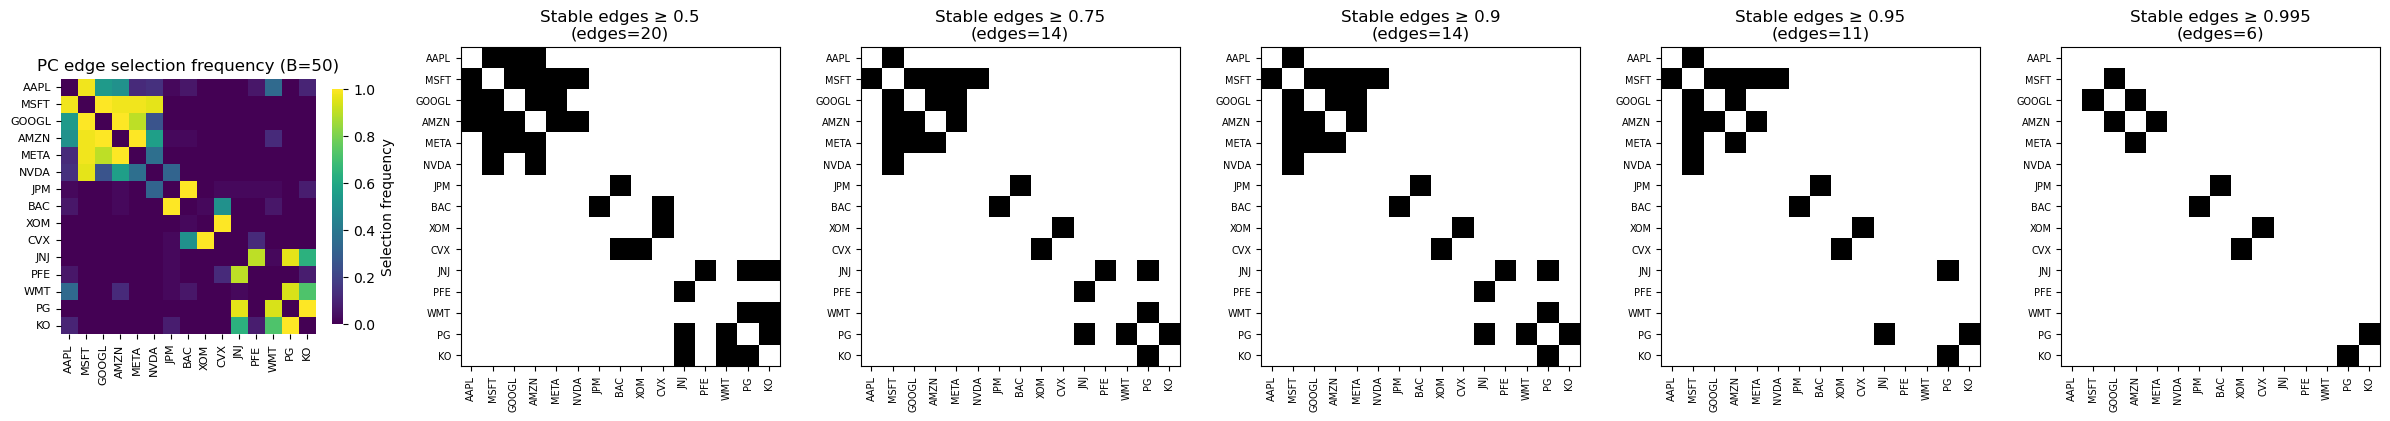

In [6]:
pc_results = pc_algorithm_hyperparameter_tuning(
    X,
    alpha_star=0.001,
    B = 50,
    thr_list = [0.5, 0.75, 0.90, 0.95, 0.995],
    savepath1=media_dir + "/pc_stability.png"
)